<h1><center>CNN Classifier</center></h1>

<h3><center>Presented by : Altaf Ur Rahman</center></h3>

***
*This notebook presents basic CNN Classifier using PyTorch. Model Architecture consist of 3 convolutional layers, batch normalization and pooling layers while relu non linearity is used. Intel Dataset consist of 6 distant classes with 14000 training and 3000 images is fed to the model for training and prediction.*
***
Following are the sections of this notebook, 

**Step 01:** *Importing librararies & setting Paths*\
**Step 02:** *Data Loading and Pre Processing*\
**Step 03**: *Network Architecture* \
**Step 04:** *Defining Loss and Optimizer*\
**Step 05:** *Model Training*\
**Step 06:** *Model Testing*\
**Step 07:** *Results Evaluation and Visualization*

***

<center> Step 01: Importing librararies & setting Paths</center>

***

In [1]:
#Load libraries
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets
import torchvision
import pathlib
import cv2

# libraries for visualization and evaluation matrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

In [2]:
#checking for device
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

#Path for training and testing directory
train_root='./data1/Intel_dataset/seg_train/seg_train'
test_root= './data1/Intel_dataset/seg_test/seg_test'

# defining some hyper parameters of the network
batch_size = 32
num_epochs= 50
num_workers = 2

***

<center>Step 02: Data Loading and Pre Processing </center>

***

In [3]:
train_transform = transforms.Compose([ transforms.Resize((150,150)),                       # Resize the image 
                                transforms.ToTensor(),                                     # Convert to Tensors
                                transforms.RandomHorizontalFlip(),                         # Data Augmentations
                                transforms.RandomRotation(degrees=15),   
                                transforms.RandomVerticalFlip(p=0.5),      
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #Mean Normalization (x-mean/STD) = [-1,1]
test_transform = transforms.Compose( [transforms.Resize((150,150)),                        # Resize the image 
                                transforms.ToTensor(),                                     # Convert to Tensors
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #Mean Normalization (x-mean/STD) = [-1,1])

In [4]:
# Lets define our datasets and dataloaders

#####################################[[[[[[[[[    Datasets    ]]]]]]]]]]]#############################################

# defining training and validation datasets [Note: This is inefficient way of loading the data: Efficient way: design custom dataset/dataloader]
train_set0 = datasets.ImageFolder(train_root )
test_set = datasets.ImageFolder(test_root ,transform=test_transform)

# Divide training set into validation set (0.25) and training set(0.75)
train_set, val_set = torch.utils.data.random_split(train_set0, [int(len(train_set0) * 0.75)+1, int(len(train_set0) * 0.25)])

#Sparse1, val_set = torch.utils.data.random_split(val_set0, [int(len(val_set0) * 0.75)+1, int(len(val_set0) * 0.25)])
train_set.dataset.transform = transforms.Compose([ transforms.Resize((150,150)),                       # Resize the image 
                                transforms.ToTensor(),                                     # Convert to Tensors
                                transforms.RandomHorizontalFlip(),                         # Data Augmentations
                                transforms.RandomRotation(degrees=15),   
                                transforms.RandomVerticalFlip(p=0.5),      
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
val_set.dataset.transform = transforms.Compose( [transforms.Resize((150,150)),                        # Resize the image 
                                transforms.ToTensor(),                                     # Convert to Tensors
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
            


######################################[[[[[[[[[    DataLoaders    ]]]]]]]]]]]#############################################

# training dataLoader
train_loader=DataLoader(
    train_set,
    batch_size= batch_size, shuffle=True, num_workers = num_workers , 
)

# testing DataLoader
val_loader=DataLoader(
    val_set,
    batch_size=batch_size, shuffle= False, )


# testing DataLoader
test_loader=DataLoader(
    test_set,
    batch_size=batch_size, shuffle= False, )



#calculating the size of training and testing images
#train_count=len(glob.glob(train_root+'/**/*.jpg'))
#test_count=len(glob.glob(test_root+'/**/*.jpg'))

train_count = len(train_set)
val_count = len(val_set)
test_count = len(test_set)


# Classes
root=pathlib.Path(train_root)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])


# Print datasets size
print(f'Training images are:     {train_count}')
print(f'Validation images are:   {val_count}')
print(f'Testing images are:      {test_count}', '\n')
print('Classes are: ',classes)

Training images are:     10526
Validation images are:   3508
Testing images are:      3000 

Classes are:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


***

 <center> Step 03: Model Architecture </center>

***

In [5]:
#CNN Network Architecture

class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (batch_size,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (batch_size,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (batch_size,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (batch_size,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (batch_size,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (batch_size,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (batch_size,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (batch_size,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (batch_size,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (batch_size,32,75,75)
        
        self.fc1=nn.Linear(in_features=75 * 75 * 32,out_features=120)
        self.fc2=nn.Linear(in_features=120,out_features=num_classes)
        
        
        
#Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
#Above output will be in matrix form, with shape (batch_size,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc1(output)
        output=self.fc2(output)
            
        return output
            

In [6]:
model=ConvNet(num_classes=6).to(device)

***

<center> Step 04: Defining Loss and Optimizer</center>

***

In [7]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.001)
loss_function=nn.CrossEntropyLoss()

***

<center> Step 05: Model Training </center>

***

In [8]:
#Let's train the model and evaluate it. Save the best model

train_log =[]
val_log = []
best_accuracy=0.0

# iterate over the number of epochs
for epoch in range(num_epochs):
    
#Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0


# load and iterate over training batches    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
# backpropagation            
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
#calculate the metrics        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
# final train accuracy and loss for the given epoch        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    


    
# Evaluation on validation dataset
    with torch.no_grad():    
        model.eval()
        val_accuracy=0.0
        val_loss = 0.0
        
# load and iterate over all batches
        for i, (images,labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())
                
#calculate the metrics                
            outputs=model(images)
            loss=loss_function(outputs,labels)
            _,prediction=torch.max(outputs.data,1)
            val_accuracy+=int(torch.sum(prediction==labels.data))
            val_loss+= loss.cpu().data*images.size(0)
            
#calculate validation accuracy and loss for this epoch       
        val_accuracy=val_accuracy/val_count
        val_loss=val_loss/val_count
        
# save the training and validation loss for this epoch
    train_log.append(train_loss.item())
    val_log.append(val_loss.item())

# print epoch results
    print('Epoch:'+str(epoch)+' Train Loss:'+str(train_loss.item())+' Val Loss:'+str(val_loss.item())+' Train Accuracy:'+str(train_accuracy)+' Val Accuracy:'+str(val_accuracy))
    
#Save the best model
    if val_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=val_accuracy
    
       

Epoch:0 Train Loss:10.22305965423584 Val Loss:1.785324215888977 Train Accuracy:0.5716321489644689 Val Accuracy:0.6898517673888256
Epoch:1 Train Loss:0.6216630339622498 Val Loss:1.1431258916854858 Train Accuracy:0.8375451263537906 Val Accuracy:0.7217787913340935
Epoch:2 Train Loss:0.22309169173240662 Val Loss:1.2759411334991455 Train Accuracy:0.9246627398821965 Val Accuracy:0.7003990877993158
Epoch:3 Train Loss:0.1431845873594284 Val Loss:1.2533074617385864 Train Accuracy:0.9563936918107543 Val Accuracy:0.7217787913340935
Epoch:4 Train Loss:0.32204294204711914 Val Loss:1.2334381341934204 Train Accuracy:0.9148774463233897 Val Accuracy:0.709521094640821
Epoch:5 Train Loss:0.21299506723880768 Val Loss:1.3340846300125122 Train Accuracy:0.9337830134904047 Val Accuracy:0.6815849486887116
Epoch:6 Train Loss:0.17466852068901062 Val Loss:1.1624605655670166 Train Accuracy:0.943853315599468 Val Accuracy:0.7129418472063854
Epoch:7 Train Loss:0.257213294506073 Val Loss:1.7340818643569946 Train Accur

In [9]:
# function to save misclassified images to the directory while testing

def save_misclassified_images(images, predictions, labels, classes, save_dir):
    misclassified_indices = (predictions != labels).nonzero()  # Get the tuple of tensors
    if misclassified_indices:  # Check if any misclassified indices exist
        misclassified_indices = misclassified_indices[0]  # Extract the first tensor if present
        for index in misclassified_indices:
            image = images[index]

            true_label = classes[labels[index].item()]  # Access the scalar value using .item()
            predicted_label = classes[predictions[index].item()]
            #true_label = classes[labels[index]]
           # predicted_label = classes[predictions[index]]
            filename = f"misclassified_{i}_{true_label}_{predicted_label}.jpg"
    
            # Normalize if needed
            if torch.is_tensor(image):
                image = image.permute(1, 2, 0).cpu().numpy()
            #plt.imsave(os.path.join(save_dir, filename), image)

            plt.imshow(image)  # Displays the image
            plt.savefig(os.path.join(save_dir, filename))  # Saves the displayed image
            plt.close()  # Closes the figure to avoid memory leaks

def show_saved_images(save_dir, num_images=5):
    saved_images = os.listdir(save_dir)[:num_images]
    for filename in saved_images:
        image = plt.imread(os.path.join(save_dir, filename))
        plt.imshow(image)
        plt.title(filename)
        plt.show()

***

<center> Step 06: Model Testing </center>

***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

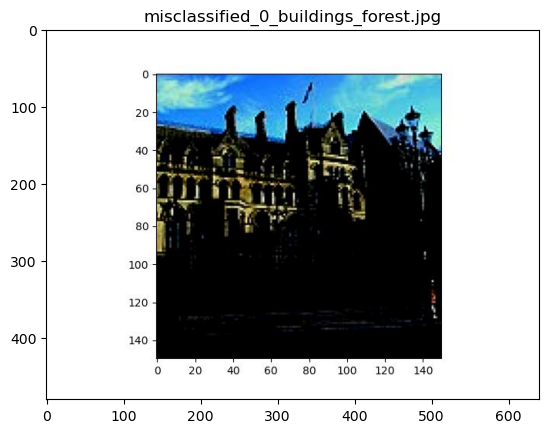

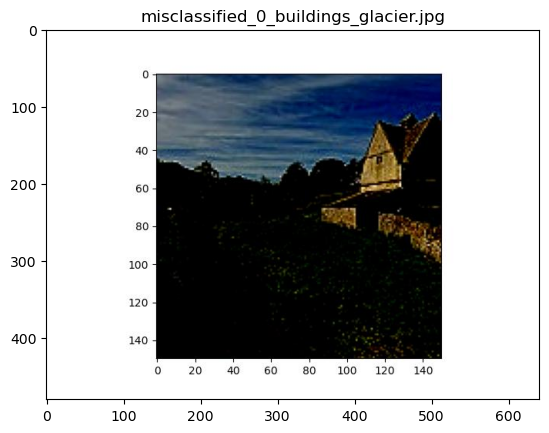

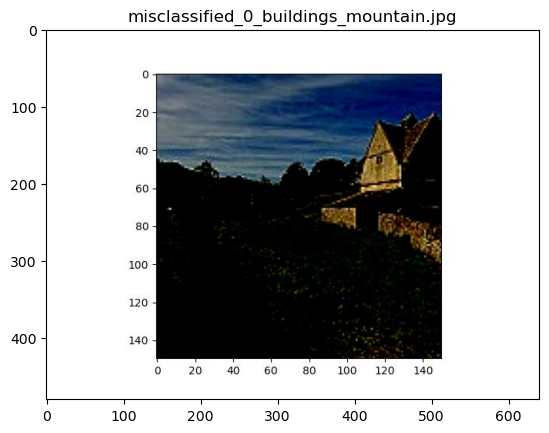

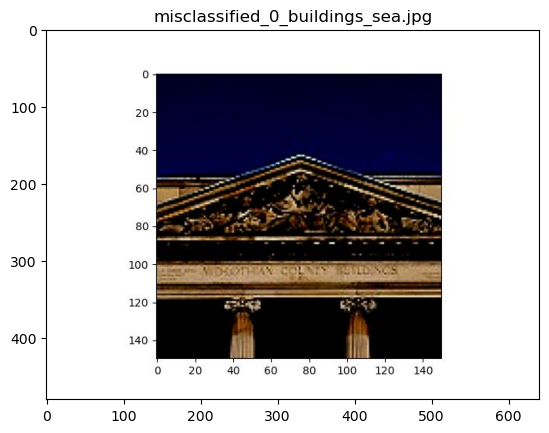

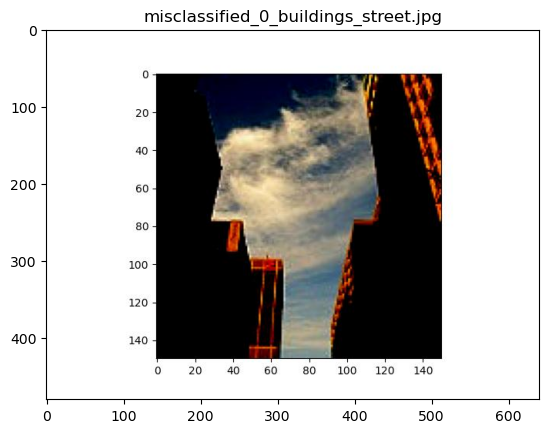

In [10]:
#testing phase

# defining directory for our misclassified samples
save_dir = "./data1/Intel_dataset/misclassified_set"

model.load_state_dict(torch.load('best_checkpoint.model'))


import matplotlib.pyplot as plt
y_pred = []
y_true = []

incorrect_examples = []
misclassified_idx = []

# iterate over test data
for i, (images,labels) in enumerate(test_loader):

# convert to cuda tensors
    if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        
# No gradients required during testing
    with torch.no_grad():
        outputs=model(images) # Feed Network
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        save_misclassified_images(images, outputs, labels, classes, save_dir)

# Later, to view the saved images:
show_saved_images(save_dir)
    
    #precision_metric.update(y_pred, y_true)
    #recall_metric.update(y_pred, y_true)
    #f1_metric.update(y_pred, y_true)

# constant for classes



***

<center> Step 07: Results Evaluation and Visualization</center>

***

In [11]:
precision = precision_score(y_true, y_pred, average = None)
recall = recall_score(y_true, y_pred, average = None)
f1 = f1_score(y_true, y_pred, average = None)

print('Classes:    ', '    '.join('%s' % classes[j] for j in range(6)))
#print('  ', Class[i] for i,n in enumerate(Classes))
print("Precision:", precision)
print("Recall:   ", recall)
print("F1-score: ", f1)

print(" Average Precision:", sum(precision)/6)
print("Average Recall:   ", sum(recall)/6)
print("Average F1-score: ", sum(f1)/6)


Classes:     buildings    forest    glacier    mountain    sea    street
Precision: [0.77581121 0.90180361 0.70558376 0.68020305 0.81882353 0.74054054]
Recall:    [0.60183066 0.94936709 0.75406872 0.76571429 0.68235294 0.82035928]
F1-score:  [0.67783505 0.92497431 0.72902098 0.72043011 0.74438503 0.77840909]
 Average Precision: 0.7704609481061198
Average Recall:    0.7622821627741784
Average F1-score:  0.7625090936684303


<AxesSubplot:>

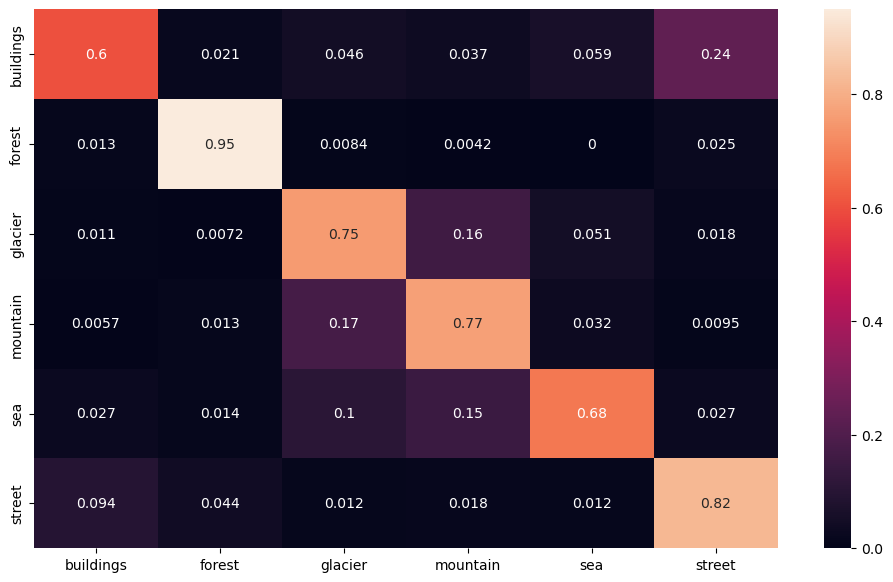

In [12]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

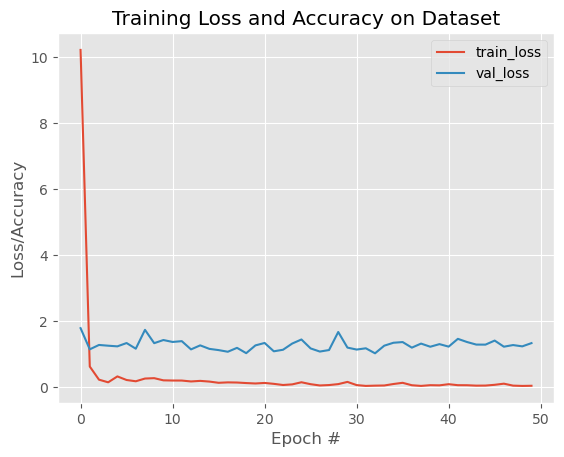

In [13]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(train_log, label="train_loss")
plt.plot(val_log, label="val_loss")
#plt.plot(H["train_acc"], label="train_acc")
#plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('train_val_loss.png')